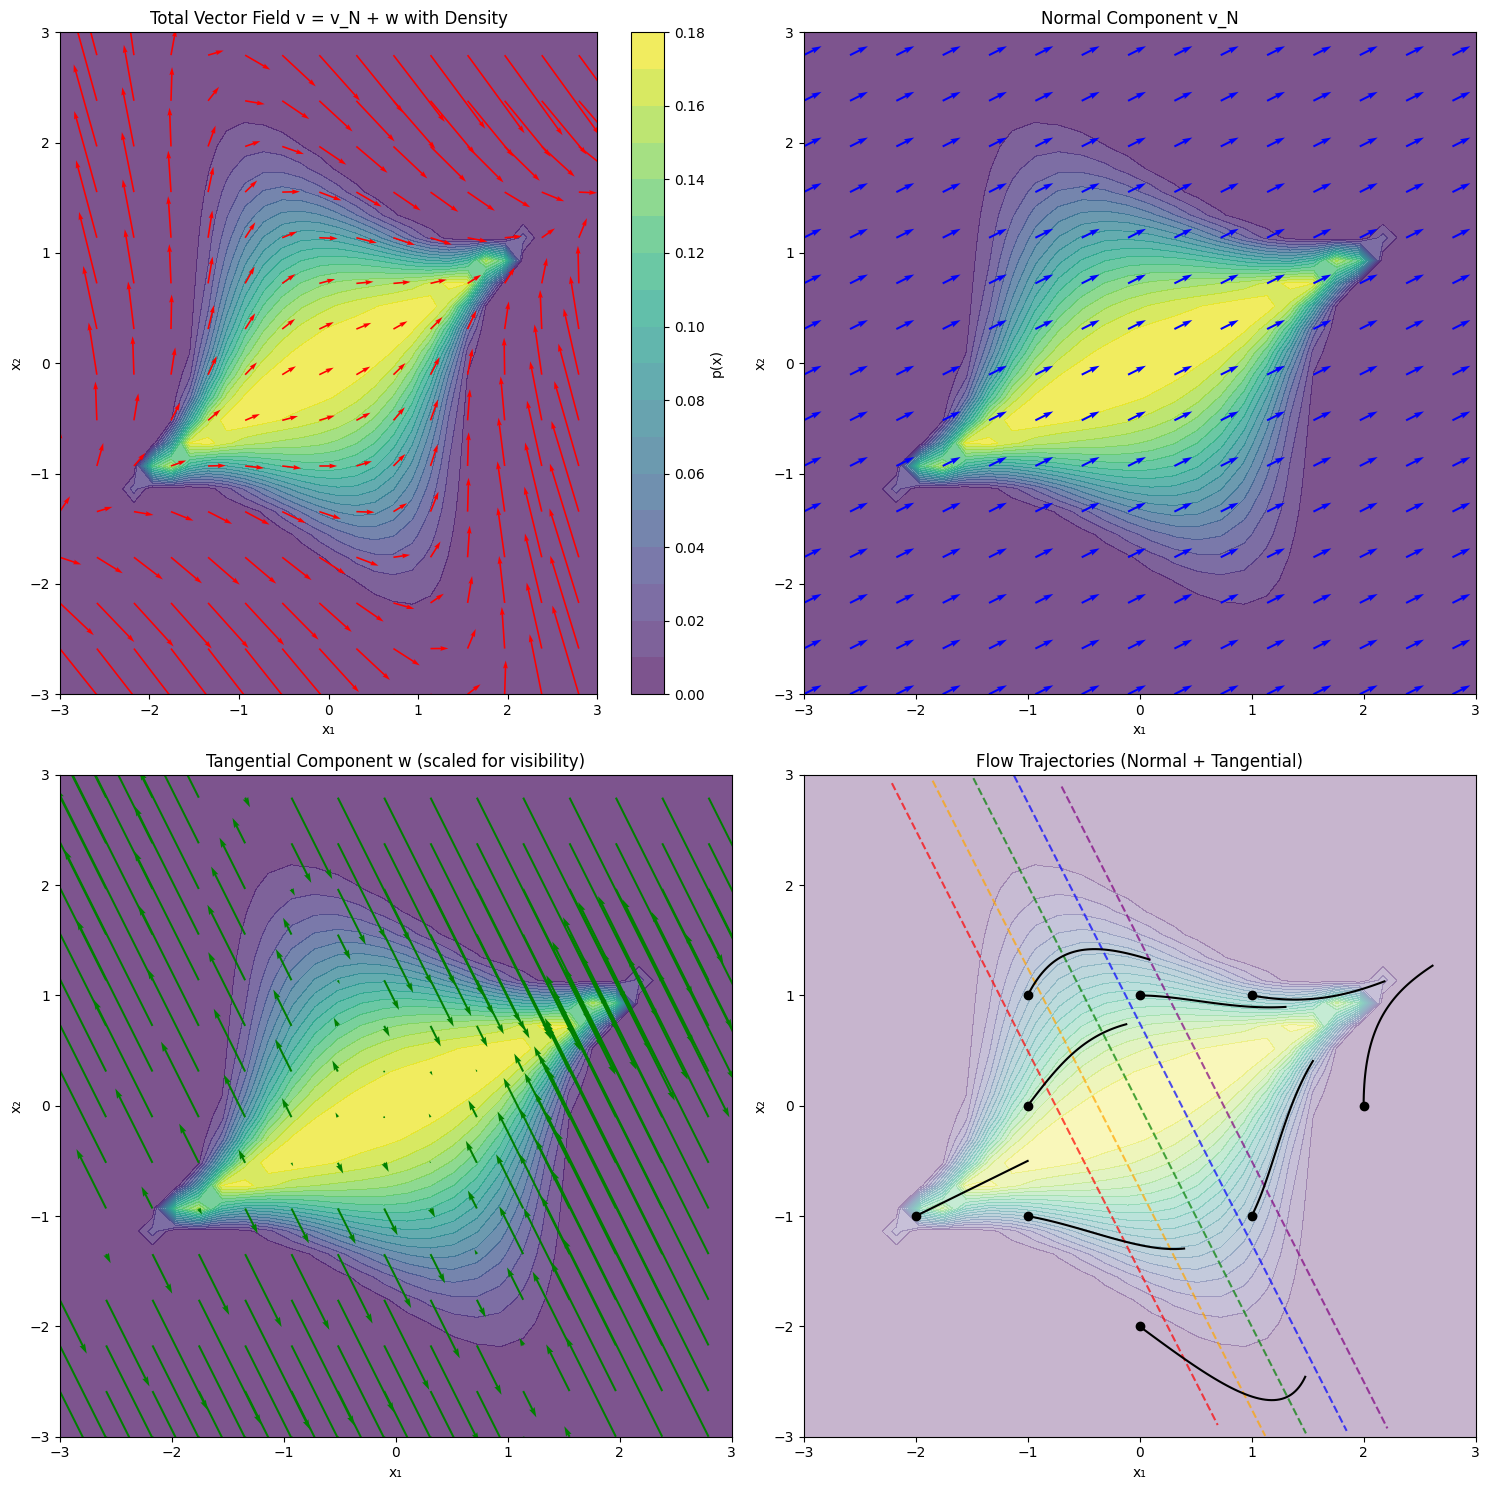

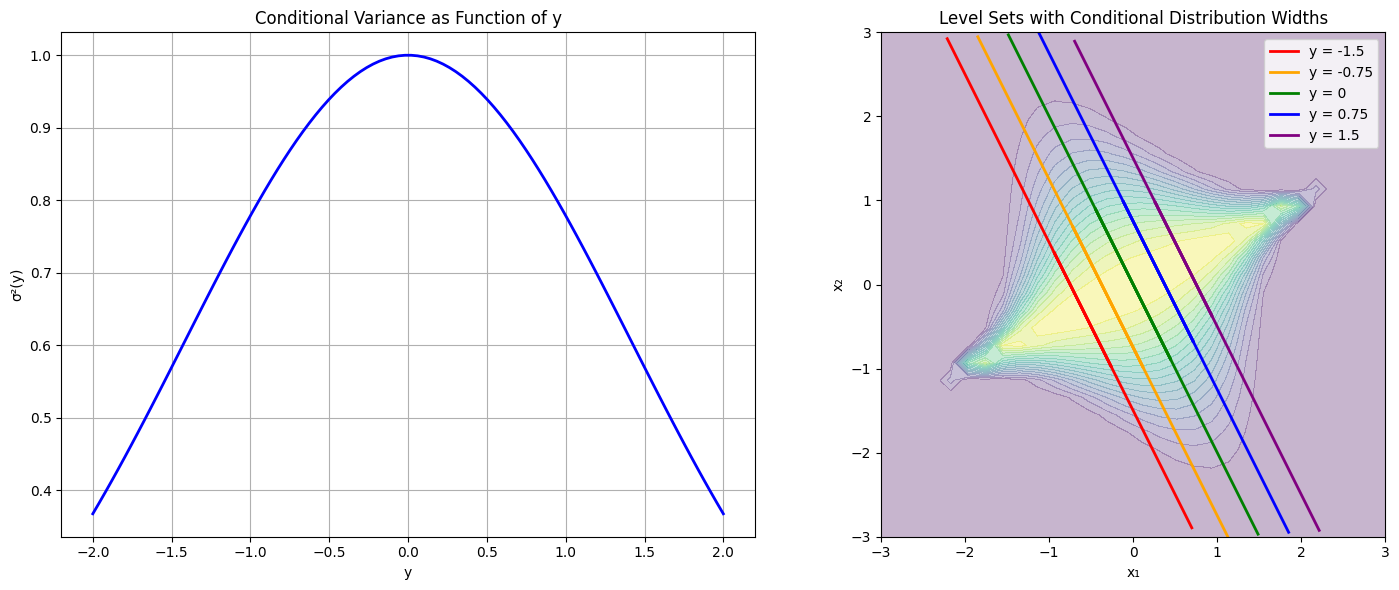

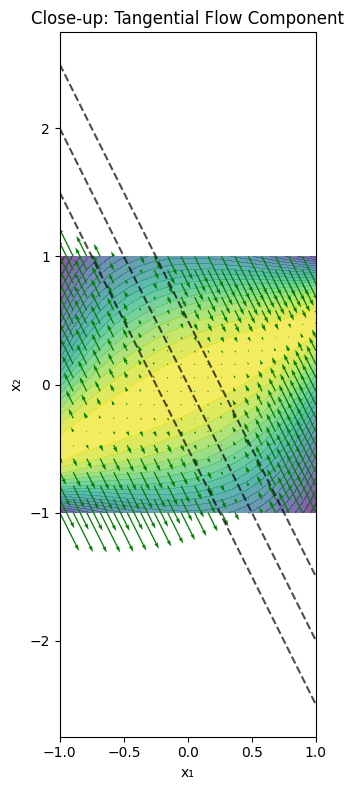

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.stats import multivariate_normal
from scipy.integrate import odeint

def construct_special_distribution(x1, x2, a, b):
    """
    Construct a distribution where conditional variance changes with y
    p(x) = p(x|y) * p(y) * |∇f|
    """
    y = a*x1 + b*x2
    
    # Marginal distribution p(y) - Gaussian
    p_y = np.exp(-y**2/8) / np.sqrt(8*np.pi)
    
    # Gradient magnitude
    grad_f_norm = np.sqrt(a**2 + b**2)
    
    # Conditional mean (on the level set)
    mean_y = np.array([a*y/(a**2+b**2), b*y/(a**2+b**2)])
    
    # Distance from mean along tangent direction
    tangent = np.array([-b, a]) / grad_f_norm
    x = np.array([x1, x2])
    dist_tangent = np.dot(x - mean_y, tangent)
    
    # Conditional variance that changes with y
    sigma2_y = np.exp(-y**2/4)  # Variance decreases away from y=0
    
    # Conditional distribution
    p_x_given_y = np.exp(-dist_tangent**2/(2*sigma2_y)) / np.sqrt(2*np.pi*sigma2_y)
    
    # Total distribution
    p_x = p_x_given_y * p_y * grad_f_norm
    
    return p_x, p_x_given_y, p_y, sigma2_y

def compute_source_term(x1, x2, a, b):
    """Compute the source term S(x) = -∇·(p*v_N)"""
    p, _, _, _ = construct_special_distribution(x1, x2, a, b)
    
    # Normal vector field
    grad_f_norm_sq = a**2 + b**2
    v_N = np.array([a, b]) / grad_f_norm_sq
    
    # Numerical gradient for source term
    h = 1e-6
    
    # Compute divergence numerically
    p_vN_x = p * v_N[0]
    p_vN_y = p * v_N[1]
    
    # ∂(p*v_N_x)/∂x
    p_plus_x, _, _, _ = construct_special_distribution(x1+h, x2, a, b)
    p_minus_x, _, _, _ = construct_special_distribution(x1-h, x2, a, b)
    div_x = (p_plus_x*v_N[0] - p_minus_x*v_N[0]) / (2*h)
    
    # ∂(p*v_N_y)/∂y
    p_plus_y, _, _, _ = construct_special_distribution(x1, x2+h, a, b)
    p_minus_y, _, _, _ = construct_special_distribution(x1, x2-h, a, b)
    div_y = (p_plus_y*v_N[1] - p_minus_y*v_N[1]) / (2*h)
    
    S = -(div_x + div_y)
    
    return S

def compute_tangential_component(x1, x2, a, b):
    """
    Compute the tangential component w(x)
    For this special case, we can derive it analytically
    """
    y = a*x1 + b*x2
    
    p, p_x_given_y, p_y, sigma2_y = construct_special_distribution(x1, x2, a, b)
    
    # Gradient of variance
    d_sigma2_dy = -y/2 * np.exp(-y**2/4)
    
    # Tangent vector (normalized)
    grad_f_norm = np.sqrt(a**2 + b**2)
    tangent = np.array([-b, a]) / grad_f_norm
    
    # Mean position on level set
    mean_y = np.array([a*y/(a**2+b**2), b*y/(a**2+b**2)])
    
    # Distance from mean along tangent
    x = np.array([x1, x2])
    dist_tangent = np.dot(x - mean_y, tangent)
    
    # Tangential component (derived analytically)
    # w = (d_sigma2_dy / (2*sigma2_y)) * dist_tangent * tangent
    w = (d_sigma2_dy / (2*sigma2_y)) * dist_tangent * tangent
    
    return w

# Parameters
a, b = 2.0, 1.0  # Coefficients for f(x) = ax₁ + bx₂

# Create grid
x_range = np.linspace(-3, 3, 30)
y_range = np.linspace(-3, 3, 30)
X, Y = np.meshgrid(x_range, y_range)

# Compute distribution and vector field components
density = np.zeros_like(X)
v_N_x = np.zeros_like(X)
v_N_y = np.zeros_like(X)
w_x = np.zeros_like(X)
w_y = np.zeros_like(Y)

grad_f_norm_sq = a**2 + b**2

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x1, x2 = X[i,j], Y[i,j]
        
        # Density
        density[i,j], _, _, _ = construct_special_distribution(x1, x2, a, b)
        
        # Normal component
        v_N_x[i,j] = a / grad_f_norm_sq
        v_N_y[i,j] = b / grad_f_norm_sq
        
        # Tangential component
        w = compute_tangential_component(x1, x2, a, b)
        w_x[i,j] = w[0]
        w_y[i,j] = w[1]

# Total vector field
v_x = v_N_x + w_x
v_y = v_N_y + w_y

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# 1. Vector field with density
ax = axes[0, 0]
cs = ax.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)
ax.quiver(X[::2,::2], Y[::2,::2], v_x[::2,::2], v_y[::2,::2], 
          scale=15, width=0.003, color='red')
ax.set_title('Total Vector Field v = v_N + w with Density')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
plt.colorbar(cs, ax=ax, label='p(x)')

# 2. Normal component
ax = axes[0, 1]
ax.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)
ax.quiver(X[::2,::2], Y[::2,::2], v_N_x[::2,::2], v_N_y[::2,::2], 
          scale=15, width=0.003, color='blue')
ax.set_title('Normal Component v_N')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')

# 3. Tangential component
ax = axes[1, 0]
ax.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.7)
# Scale up tangential component for visibility
ax.quiver(X[::2,::2], Y[::2,::2], w_x[::2,::2], w_y[::2,::2], 
          scale=5, width=0.003, color='green')
ax.set_title('Tangential Component w (scaled for visibility)')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')

# 4. Flow trajectories
ax = axes[1, 1]
ax.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.3)

# Draw level sets
y_vals = [-1.5, -0.75, 0, 0.75, 1.5]
colors = ['red', 'orange', 'green', 'blue', 'purple']

for y_val, color in zip(y_vals, colors):
    x1_vals = np.linspace(-3, 3, 100)
    x2_vals = (y_val - a*x1_vals) / b
    mask = (x2_vals >= -3) & (x2_vals <= 3)
    ax.plot(x1_vals[mask], x2_vals[mask], '--', color=color, alpha=0.7)

# Define ODE for flow
def flow_ode(state, t):
    x1, x2 = state
    # Normal component
    v_N = np.array([a, b]) / grad_f_norm_sq
    # Tangential component
    w = compute_tangential_component(x1, x2, a, b)
    # Total velocity
    v = v_N + w
    return v

# Draw flow trajectories
start_points = [[-2, -1], [-1, -1], [0, -2], [1, -1], [2, 0], 
                [1, 1], [0, 1], [-1, 1], [-1, 0]]

# start_points = [[-1/b-b/5*i*noise, -1/a+a/5*i*noise] for i,noise in zip(range(-3,4), np.random.random(7))]

for start in start_points:
    t_span = np.linspace(0, 2.5, 50)
    trajectory = odeint(flow_ode, start, t_span)
    
    ax.plot(trajectory[:, 0], trajectory[:, 1], 'k-', linewidth=1.5)
    ax.plot(trajectory[0, 0], trajectory[0, 1], 'ko', markersize=6)

ax.set_title('Flow Trajectories (Normal + Tangential)')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

# Visualize how conditional variance changes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot variance as function of y
y_range = np.linspace(-2, 2, 100)
sigma2_values = np.exp(-y_range**2/4)

ax1.plot(y_range, sigma2_values, 'b-', linewidth=2)
ax1.set_xlabel('y')
ax1.set_ylabel('σ²(y)')
ax1.set_title('Conditional Variance as Function of y')
ax1.grid(True)

# Visualize conditional distributions at different y values
ax2.contourf(X, Y, density, levels=20, cmap='viridis', alpha=0.3)

for y_val, color in zip(y_vals, colors):
    # Level set line
    x1_vals = np.linspace(-3, 3, 100)
    x2_vals = (y_val - a*x1_vals) / b
    mask = (x2_vals >= -3) & (x2_vals <= 3)
    ax2.plot(x1_vals[mask], x2_vals[mask], color=color, linewidth=2, 
            label=f'y = {y_val}')
    
    # Show variance ellipse
    mean_y = np.array([a*y_val/(a**2+b**2), b*y_val/(a**2+b**2)])
    sigma2_y = np.exp(-y_val**2/4)
    
    # Tangent direction
    tangent = np.array([-b, a]) / np.sqrt(a**2 + b**2)
    
    # Draw ellipse representing 1-sigma contour
    theta = np.linspace(0, 2*np.pi, 100)
    ellipse = mean_y[:, np.newaxis] + np.sqrt(sigma2_y) * tangent[:, np.newaxis] * np.cos(theta)
    ax2.plot(ellipse[0], ellipse[1], color=color, linewidth=2)

ax2.set_title('Level Sets with Conditional Distribution Widths')
ax2.set_xlabel('x₁')
ax2.set_ylabel('x₂')
ax2.legend()
ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

# Close-up view of tangential flow effect
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Zoom in on a region
x_zoom = np.linspace(-1, 1, 20)
y_zoom = np.linspace(-1, 1, 20)
X_zoom, Y_zoom = np.meshgrid(x_zoom, y_zoom)

# Compute components for zoomed region
w_x_zoom = np.zeros_like(X_zoom)
w_y_zoom = np.zeros_like(Y_zoom)
density_zoom = np.zeros_like(X_zoom)

for i in range(X_zoom.shape[0]):
    for j in range(X_zoom.shape[1]):
        x1, x2 = X_zoom[i,j], Y_zoom[i,j]
        density_zoom[i,j], _, _, _ = construct_special_distribution(x1, x2, a, b)
        w = compute_tangential_component(x1, x2, a, b)
        w_x_zoom[i,j] = w[0]
        w_y_zoom[i,j] = w[1]

ax.contourf(X_zoom, Y_zoom, density_zoom, levels=20, cmap='viridis', alpha=0.7)
ax.quiver(X_zoom, Y_zoom, w_x_zoom, w_y_zoom, scale=2, width=0.005, color='green')

# Draw some level sets
for y_val in [-0.5, 0, 0.5]:
    x1_vals = np.linspace(-1, 1, 100)
    x2_vals = (y_val - a*x1_vals) / b
    ax.plot(x1_vals, x2_vals, 'k--', alpha=0.7)

ax.set_title('Close-up: Tangential Flow Component')
ax.set_xlabel('x₁')
ax.set_ylabel('x₂')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Gaussian convolution

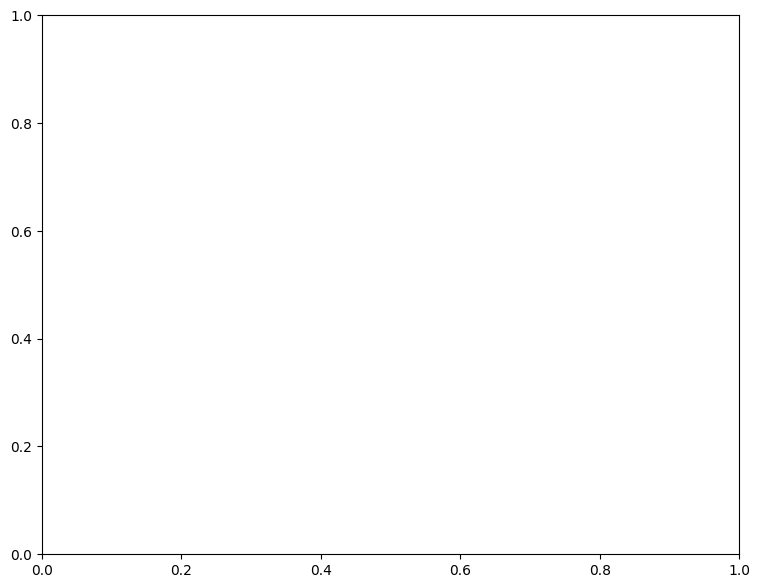

interactive(children=(FloatSlider(value=0.5, description='$c$ (Level):', max=2.0, min=-2.0, step=0.05), FloatS…

HTML(value='<h2>Part 1: Interactive 2D Visualization of Level Set Integration</h2>')

Output()

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, VBox, HBox, HTML

# --- User-Defined Functions ---
# You can change these functions f_func and p_func

def f_func_example(x, y):
    """
    Defines the function f(x,y) for level sets.
    Example: A saddle shape.
    """
    # return x**2 - y**2
    # Example 2: Ellipse
    return (x/2)**2 + y**2
    # Example 3: Wave
    # return np.sin(np.pi * x) * np.cos(np.pi * y)


def p_func_example(x, y):
    """
    Defines the ambient probability density p(x,y).
    Example: A Gaussian centered at (0.5, 0.5)
    """
    # return np.exp(-((x - 0.5)**2 + (y - 0.5)**2) / (2 * 0.5**2))
    # Example 2: Constant probability (ensure it's positive)
    return np.ones_like(x) * 1.0
    # Example 3: Another Gaussian
    # sx, sy = 1.5, 1.5
    # return (1/(2*np.pi*sx*sy)) * np.exp(-0.5 * (((x+1)/sx)**2 + ((y+1)/sy)**2))


# --- Core Numerical Functions ---

def numerical_gradient(func, x, y, h=1e-5):
    """Computes numerical gradient of func(x,y) at point (x,y)."""
    df_dx = (func(x + h, y) - func(x - h, y)) / (2 * h)
    df_dy = (func(x, y + h) - func(x, y - h)) / (2 * h)
    return df_dx, df_dy

def gaussian_2d_pdf(x, y, mu_x, mu_y, epsilon):
    """PDF of a 2D Gaussian with isotropic covariance epsilon^2 * I."""
    if epsilon <= 1e-6: # Avoid division by zero for very small epsilon
        # Treat as delta function, high value if (x,y) is very close to (mu_x, mu_y)
        # This is a simplification for visualization; proper limit is more complex.
        # For integration purposes, if epsilon is tiny, integral will be approx value at center.
        return np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / (2 * (1e-6)**2)) / (2 * np.pi * (1e-6)**2)

    return (1 / (2 * np.pi * epsilon**2)) * np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / (2 * epsilon**2))


def integrate_on_level_set_contour(
    contour_paths,
    test_g_func, # e.g., the Gaussian test function N((mu_x,mu_y), epsilon^2 I)(x',y')
    ambient_p_func,
    level_f_func,
    grad_epsilon=1e-8 # Small value to add to ||grad f|| denominator
):
    """
    Numerically integrates test_g_func * (ambient_p_func / ||grad(level_f_func)||) * ds
    along the provided contour_paths.
    
    contour_paths: A list of matplotlib Path objects (or similar structure with vertices).
    """
    total_integral = 0.0

    if not contour_paths:
        return 0.0

    for path_obj in contour_paths:
        if isinstance(path_obj, list): # If find_contours output is used directly
             vertices = path_obj
        elif hasattr(path_obj, 'vertices'): # For Path objects from plt.contour
             vertices = path_obj.vertices
        else:
            print(f"Warning: Unknown contour path object type: {type(path_obj)}")
            continue


        if len(vertices) < 2:
            continue

        for i in range(len(vertices) - 1):
            p1 = vertices[i]
            p2 = vertices[i+1]

            mid_x = (p1[0] + p2[0]) / 2
            mid_y = (p1[1] + p2[1]) / 2
            
            ds = np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
            if ds == 0:
                continue

            # Evaluate functions at midpoint
            g_val = test_g_func(mid_x, mid_y)
            p_val = ambient_p_func(mid_x, mid_y)
            
            # Numerical gradient of f at midpoint
            grad_fx, grad_fy = numerical_gradient(level_f_func, mid_x, mid_y)
            norm_grad_f = np.sqrt(grad_fx**2 + grad_fy**2) + grad_epsilon
            
            if p_val < 0: # Ambient density should be non-negative
                p_val = 0

            integrand_part = g_val * (p_val / norm_grad_f)
            total_integral += integrand_part * ds
            
    return total_integral

# --- Plotting and Interaction ---
# Define plot domain and grid
plot_lim = 2.0
grid_points = 100 # For contour finding and p_func visualization
x_coords = np.linspace(-plot_lim, plot_lim, grid_points)
y_coords = np.linspace(-plot_lim, plot_lim, grid_points)
X_grid, Y_grid = np.meshgrid(x_coords, y_coords)

# Evaluate user-defined functions on the grid for initial display (optional)
P_grid = p_func_example(X_grid, Y_grid) # Ambient density

# Create figure and axis outside the update function for persistence
fig_interactive, ax_interactive = plt.subplots(figsize=(9, 7))

# Output widget for messages or errors
output_info = widgets.Output()

def update_interactive_plot(c_level, mu_x, mu_y, epsilon_std, f_choice, p_choice):
    with output_info: # Capture prints and errors here
        output_info.clear_output(wait=True) # Clear previous messages
        
        ax_interactive.clear() # Clear previous plot elements

        # Select the actual functions based on choice
        if f_choice == 'Saddle':
            current_f_func = lambda x, y: x**2 - y**2
        elif f_choice == 'Ellipse':
            current_f_func = lambda x, y: (x/2)**2 + y**2
        elif f_choice == 'Wave':
            current_f_func = lambda x, y: np.sin(np.pi * x) * np.cos(np.pi * y)
        else: # Default
            current_f_func = f_func_example
            
        if p_choice == 'Gaussian':
            current_p_func = lambda x, y: np.exp(-((x - 0.5)**2 + (y - 0.5)**2) / (2 * 0.5**2))
        elif p_choice == 'Constant':
            current_p_func = lambda x, y: np.ones_like(x) * 1.0
        else: # Default
            current_p_func = p_func_example

        # 1. Evaluate f(x,y) on the grid for finding the level set
        F_grid = current_f_func(X_grid, Y_grid)

        # 2. Find the level set contour f(x,y) = c_level
        # For matplotlib.pyplot.contour, it returns a QuadContourSet
        contour_set = ax_interactive.contour(X_grid, Y_grid, F_grid, levels=[c_level], colors='red', linewidths=2)
        level_set_paths = contour_set.collections[0].get_paths() if contour_set.collections else []
        ax_interactive.set_title(f'Level Set $f(x,y)={c_level:.2f}$') # Temp title

        # 3. Define the Gaussian test function for integration
        # This is N((mu_x, mu_y), epsilon_std^2 * I)
        # The arguments (mx,my,eps) are fixed for this specific integration
        # The variables of integration are (x',y') on the level set
        def current_gaussian_test_func(x_prime, y_prime):
            return gaussian_2d_pdf(x_prime, y_prime, mu_x, mu_y, epsilon_std)

        # 4. Calculate the integral (value of convolved density at (mu_x, mu_y))
        integral_value = integrate_on_level_set_contour(
            level_set_paths,
            current_gaussian_test_func,
            current_p_func,
            current_f_func
        )

        # 5. Visualization
        # Optional: Plot ambient probability density p(x,y)
        P_grid_current = current_p_func(X_grid, Y_grid)
        ax_interactive.contourf(X_grid, Y_grid, P_grid_current, levels=10, alpha=0.3, cmap='viridis')
        
        # Plot level set (already done by ax_interactive.contour, but ensure it's on top if filled contourf is used)
        if contour_set.collections: # Re-plot if necessary or adjust zorder
             for collection in contour_set.collections:
                collection.set_zorder(10) # Ensure level set is visible

        # Plot Gaussian test function contours
        G_on_grid = gaussian_2d_pdf(X_grid, Y_grid, mu_x, mu_y, epsilon_std)
        ax_interactive.contour(X_grid, Y_grid, G_on_grid, levels=5, colors='blue', alpha=0.7, linestyles='--')
        ax_interactive.scatter([mu_x], [mu_y], color='blue', s=40, zorder=11, label='Gaussian Center')
        
        ax_interactive.set_xlabel('$x$')
        ax_interactive.set_ylabel('$y$')
        ax_interactive.set_xlim([-plot_lim, plot_lim])
        ax_interactive.set_ylim([-plot_lim, plot_lim])
        ax_interactive.set_aspect('equal', adjustable='box')
        ax_interactive.grid(True, linestyle='--', alpha=0.5)
        # ax_interactive.set_title(f'$f(x,y)={c_level:.2f}$. Integral Value $\approx {integral_value:.4e}$')
        ax_interactive.legend(loc='upper right')
        
        # Redraw the main figure for Jupyter
        display(fig_interactive)
        # To prevent duplicate figures in some Jupyter setups if interact is called multiple times
        # plt.close(fig_interactive) # but this might close it too soon before display.
                                    # The fig object is reused, so this should be okay.


# --- Define Widgets ---
c_slider = FloatSlider(min=-2.0, max=2.0, step=0.05, value=0.5, description='$c$ (Level):')
mux_slider = FloatSlider(min=-plot_lim, max=plot_lim, step=0.1, value=0.0, description='$\mu_x$:')
muy_slider = FloatSlider(min=-plot_lim, max=plot_lim, step=0.1, value=0.0, description='$\mu_y$:')
epsilon_slider = FloatSlider(min=0.05, max=1.0, step=0.05, value=0.3, description='$\epsilon$ (StdDev):')

f_dropdown = widgets.Dropdown(
    options=['Saddle', 'Ellipse', 'Wave', 'Custom f_func_example'],
    value='Ellipse',
    description='Func f(x,y):'
)
p_dropdown = widgets.Dropdown(
    options=['Gaussian', 'Constant', 'Custom p_func_example'],
    value='Constant',
    description='Density p(x,y):'
)

# Use HBox and VBox for better layout if many controls
controls = VBox([
    HBox([f_dropdown, p_dropdown]),
    HBox([c_slider, epsilon_slider]),
    HBox([mux_slider, muy_slider])
])

# Create the interactive layout
interactive_plot_ui = interact.options(manual=True, manual_name="Update Plot")(
    update_interactive_plot, 
    c_level=c_slider, 
    mu_x=mux_slider, 
    mu_y=muy_slider, 
    epsilon_std=epsilon_slider,
    f_choice=f_dropdown,
    p_choice=p_dropdown
)

# Display section
html_title_part1 = HTML("<h2>Part 1: Interactive 2D Visualization of Level Set Integration</h2>")
display(html_title_part1)
display(controls)
# The plot will appear below the "Update Plot" button generated by interact with manual=True
# The output_info widget will display prints/errors if any occur during update_interactive_plot
display(output_info)

# Initial explicit call to draw the plot when the cell is first run.
# This is needed because manual=True means it won't run until button press.
# However, interact with manual=True creates its own button.
# We will rely on the user to press "Update Plot".
# If you want an initial plot without pressing the button, you might call
# update_interactive_plot directly with default values, but then ensure fig is handled correctly.
# For now, this setup is cleaner.

HTML(value='<h2>Part 2: Interactive 3D Visualization of Convolved Density $h(x,y)$</h2>')

/var/folders/nc/zbqbbkkx08z7v1g3mlf8bdn00000gn/T/ipykernel_94590/2849662101.py:36: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  level_set_paths_3d_calc = contour_set_3d_calc.collections[0].get_paths() if contour_set_3d_calc.collections else []


Calculating convolved density for 3D plot (this may take some time)...
  Progress: 5.0%
  Progress: 10.0%
  Progress: 15.0%
  Progress: 20.0%
  Progress: 25.0%
  Progress: 30.0%
  Progress: 35.0%
  Progress: 40.0%
  Progress: 45.0%
  Progress: 50.0%
  Progress: 55.0%
  Progress: 60.0%
  Progress: 65.0%
  Progress: 70.0%
  Progress: 75.0%
  Progress: 80.0%
  Progress: 85.0%
  Progress: 90.0%
  Progress: 95.0%
  Progress: 100.0%
Convolved density calculation complete.


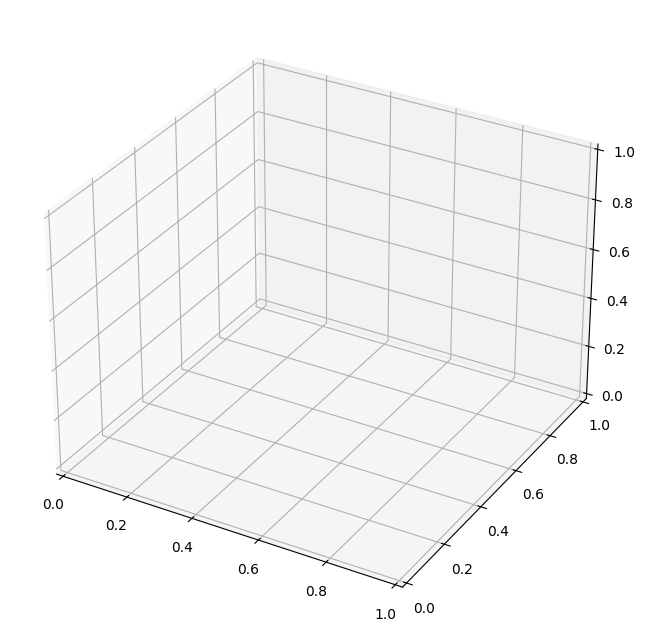

interactive(children=(FloatSlider(value=30.0, description='Azimuth (Z-Rot):', max=360.0, step=5.0), FloatSlide…

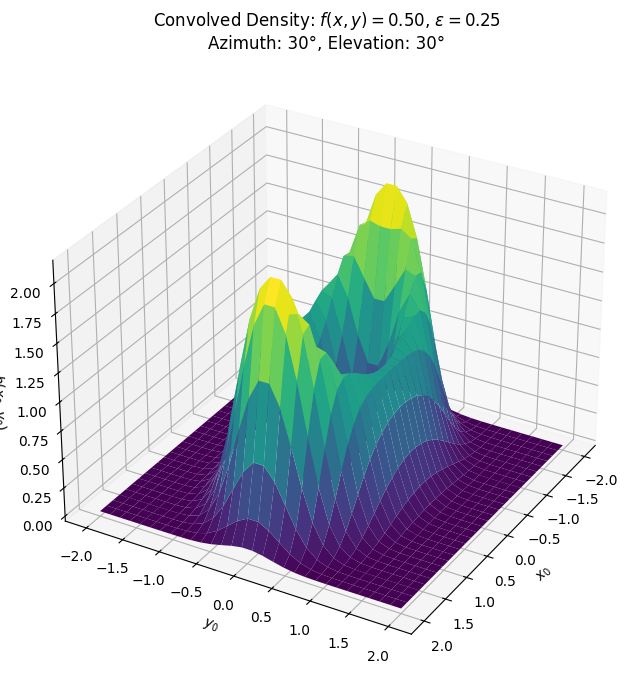

Output()

In [5]:
# Ensure Part 1 code block has been run if you are using f_func_example, p_func_example, etc.
# or if you want to use functions selected/defined there.

# --- Part 2: Interactive 3D Visualization of Convolved Density (with rotation) ---
from mpl_toolkits.mplot3d import Axes3D
# Import ipywidgets if not already imported from Part 1
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, VBox, HTML
import matplotlib.pyplot as plt # Ensure matplotlib.pyplot is imported
import numpy as np # Ensure numpy is imported

# Function calculate_convolved_density_on_grid is assumed to be defined from Part 1's context
# or needs to be re-defined here if running this block standalone.
# For clarity, let's copy it here (or ensure it's accessible).

# --- (Re-include or ensure accessibility of necessary functions from Part 1 if needed) ---
# For example: numerical_gradient, gaussian_2d_pdf, integrate_on_level_set_contour
# If this cell is run independently, these must be defined. Let's assume they are accessible
# from the execution of the previous cell (Part 1).
# If not, uncomment and paste their definitions here.
# def numerical_gradient(func, x, y, h=1e-5): ...
# def gaussian_2d_pdf(x, y, mu_x, mu_y, epsilon): ...
# def integrate_on_level_set_contour(...): ...

# Re-define calculate_convolved_density_on_grid if it's not in the same execution flow easily
# (or ensure it is)
def calculate_convolved_density_on_grid(
    x_grid_coords, y_grid_coords, c_level_fixed, epsilon_fixed,
    level_f_func, ambient_p_func,
    domain_x_coords, domain_y_coords, grad_epsilon=1e-8
):
    temp_fig_calc, temp_ax_calc = plt.subplots()
    Domain_X_grid_calc, Domain_Y_grid_calc = np.meshgrid(domain_x_coords, domain_y_coords)
    F_on_domain_grid_calc = level_f_func(Domain_X_grid_calc, Domain_Y_grid_calc)
    contour_set_3d_calc = temp_ax_calc.contour(Domain_X_grid_calc, Domain_Y_grid_calc, F_on_domain_grid_calc, levels=[c_level_fixed])
    level_set_paths_3d_calc = contour_set_3d_calc.collections[0].get_paths() if contour_set_3d_calc.collections else []
    plt.close(temp_fig_calc)

    if not level_set_paths_3d_calc:
        print(f"Warning: No level set found for c={c_level_fixed} in the given domain for 3D plot.")
        return None, None, np.zeros((len(y_grid_coords), len(x_grid_coords))) # Return None for grids too

    Eval_X_grid_calc, Eval_Y_grid_calc = np.meshgrid(x_grid_coords, y_grid_coords)
    H_values_calc = np.zeros_like(Eval_X_grid_calc)
    total_points_calc = len(x_grid_coords) * len(y_grid_coords)
    current_point_calc = 0
    print("Calculating convolved density for 3D plot (this may take some time)...")
    for i in range(len(x_grid_coords)):
        for j in range(len(y_grid_coords)):
            x0 = Eval_X_grid_calc[j, i]
            y0 = Eval_Y_grid_calc[j, i]
            def kernel_func_for_integration_calc(x_prime, y_prime):
                return gaussian_2d_pdf(x_prime, y_prime, x0, y0, epsilon_fixed)
            H_values_calc[j, i] = integrate_on_level_set_contour(
                level_set_paths_3d_calc, kernel_func_for_integration_calc,
                ambient_p_func, level_f_func, grad_epsilon
            )
            current_point_calc += 1
            if current_point_calc % (max(1, total_points_calc // 20)) == 0:
                 print(f"  Progress: { (current_point_calc/total_points_calc)*100 :.1f}%")
    print("Convolved density calculation complete.")
    return Eval_X_grid_calc, Eval_Y_grid_calc, H_values_calc


# --- Parameters for the 3D plot ---
# These should be defined before running the calculation.
# You can set these based on your Part 1 exploration or define new ones.
plot_lim_3d_domain = 2.0 # Domain limit for visualization and level set finding
grid_points_3d_domain = 100 # For finding level set contours

# Choose which f and p functions to use for the 3D plot
f_choice_3d_interactive = 'Ellipse' # Options: 'Saddle', 'Ellipse', 'Wave', 'Custom f_func_example'
p_choice_3d_interactive = 'Constant'  # Options: 'Gaussian', 'Constant', 'Custom p_func_example'

# Select functions based on choices (ensure these lambda/functions are defined as in Part 1)
if f_choice_3d_interactive == 'Saddle':
    selected_f_func_3d_interactive = lambda x, y: x**2 - y**2
elif f_choice_3d_interactive == 'Ellipse':
    selected_f_func_3d_interactive = lambda x, y: (x/2)**2 + y**2
elif f_choice_3d_interactive == 'Wave':
    selected_f_func_3d_interactive = lambda x, y: np.sin(np.pi * x) * np.cos(np.pi * y)
else: # Default to f_func_example if defined, or a placeholder
    selected_f_func_3d_interactive = f_func_example if 'f_func_example' in globals() else lambda x,y: x**2+y**2
    
if p_choice_3d_interactive == 'Gaussian':
    selected_p_func_3d_interactive = lambda x, y: np.exp(-((x - 0.5)**2 + (y - 0.5)**2) / (2 * 0.5**2))
elif p_choice_3d_interactive == 'Constant':
    selected_p_func_3d_interactive = lambda x, y: np.ones_like(x) * 1.0
else: # Default to p_func_example if defined, or a placeholder
    selected_p_func_3d_interactive = p_func_example if 'p_func_example' in globals() else lambda x,y: np.ones_like(x)

c_level_3d_interactive = 0.5
epsilon_3d_interactive = 0.25

# Grid for evaluating the convolved density h(x,y)
eval_grid_points_3d_interactive = 30 # Lower for faster, increase for resolution
x_eval_3d_interactive = np.linspace(-plot_lim_3d_domain, plot_lim_3d_domain, eval_grid_points_3d_interactive)
y_eval_3d_interactive = np.linspace(-plot_lim_3d_domain, plot_lim_3d_domain, eval_grid_points_3d_interactive)

# Domain for finding the level set
domain_x_3d_interactive = np.linspace(-plot_lim_3d_domain -0.5, plot_lim_3d_domain + 0.5, grid_points_3d_domain)
domain_y_3d_interactive = np.linspace(-plot_lim_3d_domain -0.5, plot_lim_3d_domain + 0.5, grid_points_3d_domain)

# --- Perform the (slow) calculation ONCE ---
html_title_part2_interactive = HTML("<h2>Part 2: Interactive 3D Visualization of Convolved Density $h(x,y)$</h2>")
display(html_title_part2_interactive)

# Store calculated data globally or pass it effectively.
# Using global makes it simpler for interact if function def is simple.
X_h_grid_global, Y_h_grid_global, H_convolved_values_global = calculate_convolved_density_on_grid(
    x_eval_3d_interactive, y_eval_3d_interactive,
    c_level_3d_interactive, epsilon_3d_interactive,
    selected_f_func_3d_interactive, selected_p_func_3d_interactive,
    domain_x_3d_interactive, domain_y_3d_interactive
)

# --- Interactive plotting function for 3D view ---
# We need a figure object that persists for updates by the slider
fig3d_interactive = plt.figure(figsize=(10, 8))
ax3d_interactive = fig3d_interactive.add_subplot(111, projection='3d')
# Initial plot (will be updated by slider)
# It's better to do the first plot within the function called by interact
# to ensure the axis object is correctly handled.

plot_is_initialized = False # Flag to manage initial plot elements like colorbar

def plot_3d_convolved_surface(azimuth, elevation):
    global plot_is_initialized # Use a flag to add colorbar only once

    ax3d_interactive.clear() # Clear previous view

    if X_h_grid_global is not None and np.any(H_convolved_values_global):
        surf = ax3d_interactive.plot_surface(
            X_h_grid_global, Y_h_grid_global, H_convolved_values_global,
            cmap='viridis', edgecolor='none'
        )
        # Add colorbar only once or if it's cleared.
        # A bit tricky with interact; let's try adding it if no children axes for colorbar exist.
        # A simpler way: add it once if a global flag indicates not added.
        if not plot_is_initialized and hasattr(fig3d_interactive, 'colorbar'):
             # fig3d_interactive.colorbar(surf, ax=ax3d_interactive, shrink=0.5, aspect=10, label='h(x,y)')
             # The above line can cause issues with repeated calls.
             # Colorbar is best added once if the mappable (surf) doesn't change.
             # For simplicity, we might omit the colorbar in interactive updates if it's problematic
             # or ensure it's managed carefully.
             # A common pattern is to create it once and store its reference.
             pass # Colorbar can be tricky with clearing and redrawing. Often added outside if data is static.


        ax3d_interactive.set_xlabel('$x_0$')
        ax3d_interactive.set_ylabel('$y_0$')
        ax3d_interactive.set_zlabel('$h(x_0, y_0)$')
        title_str = (f'Convolved Density: $f(x,y)={c_level_3d_interactive:.2f}$, '
                     f'$\epsilon={epsilon_3d_interactive:.2f}$\n'
                     f'Azimuth: {azimuth:.0f}°, Elevation: {elevation:.0f}°')
        ax3d_interactive.set_title(title_str)
        ax3d_interactive.view_init(elev=elevation, azim=azimuth)
    else:
        ax3d_interactive.text2D(0.5, 0.5, "Convolved density is zero or level set not found.", 
                    transform=ax3d_interactive.transAxes, ha='center', va='center')
        ax3d_interactive.set_title("Data not available for plotting")

    # To display in Jupyter notebook within the interact framework:
    # display(fig3d_interactive) # This might create multiple plots if not handled carefully.
    # Instead, rely on the fact that interact shows the output of the function.
    # For matplotlib, the figure is updated in place.
    # No explicit plt.show() inside the function called by interact.
    # The figure fig3d_interactive should be displayed once after the cell defining interact.

# Sliders for viewing angles
azimuth_slider_3d = FloatSlider(min=0, max=360, step=5, value=30, description='Azimuth (Z-Rot):')
elevation_slider_3d = FloatSlider(min=-90, max=90, step=5, value=30, description='Elevation:')

# Output widget for this part as well
output_info_part2 = widgets.Output()

with output_info_part2:
    if X_h_grid_global is None or not np.any(H_convolved_values_global):
        print("Note: Data for 3D plot was not successfully calculated (e.g., level set not found). "
              "Rotation will show an empty plot or error message.")

# Create the interaction. The figure 'fig3d_interactive' is implicitly used.
interactive_3d_view = interact(
    plot_3d_convolved_surface,
    azimuth=azimuth_slider_3d,
    elevation=elevation_slider_3d
)

# Display the figure once. Interact will update it.
# This is important: the figure object `fig3d_interactive` is created *before* interact is called.
# Interact then uses the function `plot_3d_convolved_surface` which modifies this existing figure.
display(fig3d_interactive)
display(output_info_part2)

